In [1]:
from cVAE_GAN import VAE_MNIST
import torch 
from Target_model import MLP_MNIST,CNN_MNIST
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from torchvision import transforms
from torchvision import datasets
from AdvSampleUtil import AdvSampleGenerator
import torch.nn as nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#加载目标模型
# model=MLP_MNIST()
# model.load_state_dict(torch.load("./model/mnist_mlp.pth"))
# model.to(device)

model=CNN_MNIST()
model.load_state_dict(torch.load("E:/Project/ModelAndDataset/model/mnist_cnn.pth"))
model.to(device)



estimator=PyTorchClassifier(model=model,loss=nn.CrossEntropyLoss(),
                            optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
                            input_shape=(1,28,28), 
                            nb_classes=10)
#定义攻击器
attacker = FastGradientMethod(estimator, eps=0.1)
#加载数据
img_transform = transforms.Compose([
    transforms.ToTensor(),])
mnist_test= datasets.MNIST(
    root='E:/Project/ModelAndDataset/data', train=False, transform=img_transform, download=True
)
advSampleGenerator=AdvSampleGenerator(model,mnist_test,attacker,False,device)
samplePairs=advSampleGenerator.generate(1000)

d:\Anaconda\envs\AdversarialSampleDetection\lib\site-packages\torch\nn\modules\module.py:1519: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


raw_predicted: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
adv_predicted: tensor([7, 2, 8, 2, 4, 1, 8, 9, 6, 9, 0, 8, 4, 0, 3, 3, 9, 7, 8, 4, 4, 6, 6, 5,
        4, 0, 7, 4, 2, 1, 3, 3, 3, 2, 7, 2, 2, 1, 2, 1, 8, 2, 4, 2, 3, 8, 3, 2,
        4, 4, 6, 3, 3, 9, 8, 2, 4, 2, 9, 8, 7, 8, 8, 8], device='cuda:0')
comparison: tensor([ True,  True, False, False,  True,  True, False,  True, False,  True,
         True, False, False,  True, False, False,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True, False,  True,  True, False,  True,  True,  True,
        False, False,  True,  True,  True, False, False,  True,  True,  True,
         True,  True, False, False, False, False,  True, False,  True, False,
         True,  True, 

In [3]:
vae=VAE_MNIST(100,device)
vae.load_state_dict(torch.load('E:/Project/ModelAndDataset/model/CVAE-GAN-VAE.pth'))
vae=vae.to(device)

In [4]:
import numpy as np
from AdvSampleUtil import EvaluateImage,DrawResult,cosine_similarity
r_mse_np=np.array([])
r_l2_np=np.array([])
r_ssim_np=np.array([])


a_mse_np=np.array([])
a_l2_np=np.array([])
a_ssim_np=np.array([])

for pair in samplePairs:
    label_onehot=torch.zeros(10)
    label_onehot[int(pair.adv_label)]=1

    # z = torch.randn(100,device=device)
    # z = torch.cat([z,label_onehot.to(device)],0)

    z,_,_=vae.encoder(torch.tensor(pair.adv_img).unsqueeze(0).unsqueeze(1).to(device))
    label_onehot=label_onehot.to(device)
    z =torch.cat([z.squeeze(),label_onehot],0)

    g_img=vae.decoder(z).view(1,28,28).detach().squeeze().cpu().numpy()
    r_img=pair.raw_img
    a_img=pair.adv_img
    #评估原始图片与生成图片
    r_mse,r_l2,r_ssim=EvaluateImage(r_img,g_img)
    r_mse_np=np.append(r_mse_np,r_mse)
    r_l2_np=np.append(r_l2_np,r_l2)
    r_ssim_np=np.append(r_ssim_np,r_ssim)
    #评估对抗样本与生成图片
    a_mse,a_l2,a_ssim=EvaluateImage(a_img,g_img)
    a_mse_np=np.append(a_mse_np,a_mse)
    a_l2_np=np.append(a_l2_np,a_l2)
    a_ssim_np=np.append(a_ssim_np,a_ssim)
    # #比较编码器提取的潜在向量
    # r_z,_,_=vae.encoder(torch.tensor(r_img).unsqueeze(0).unsqueeze(1).to(device))
    # a_z,_,_=vae.encoder(torch.tensor(a_img).unsqueeze(0).unsqueeze(1).to(device))
    # g_z,_,_=vae.encoder(torch.tensor(g_img).unsqueeze(0).unsqueeze(1).to(device))
    # r_cosine=cosine_similarity(r_z.squeeze(),g_z.squeeze()).detach().cpu()
    # a_cosine=cosine_similarity(a_z.squeeze(),g_z.squeeze()).detach().cpu() 
    # r_cosine_np=np.append(r_cosine_np,r_cosine)
    # # print(r_cosine)
    # a_cosine_np=np.append(a_cosine_np,a_cosine)
    # # print(a_cosine)
    
      
print("MSE:{} L2_distance:{} SSIM:{}".format(np.sum(np.less(r_mse_np,a_mse_np)),
                                             np.sum(np.less(r_l2_np,a_l2_np)),
                                             np.sum(np.greater(r_ssim_np,a_ssim_np))
                                             ))

MSE:876 L2_distance:876 SSIM:999


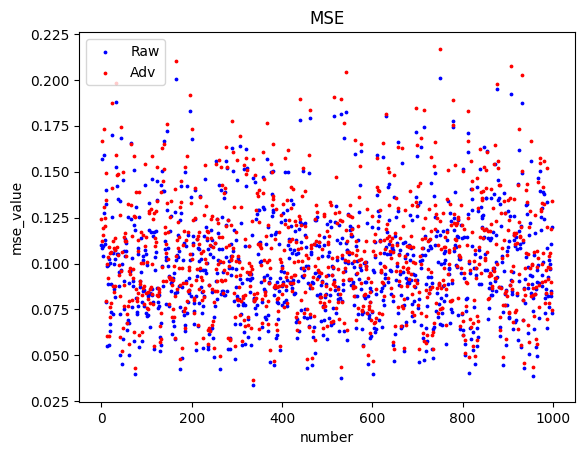

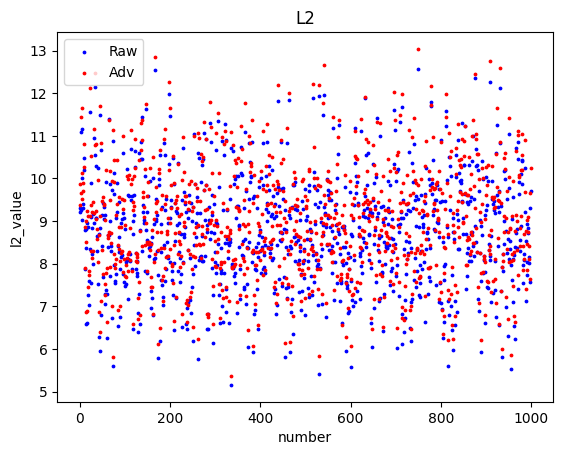

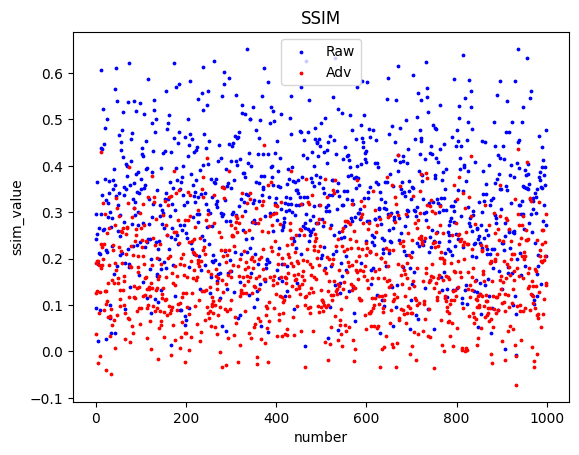

In [5]:
import matplotlib.pyplot as plt
fig1=DrawResult(r_mse_np,a_mse_np,"MSE","number","mse_value")
plt.show(fig1)
fig2=DrawResult(r_l2_np,a_l2_np,"L2","number","l2_value")
plt.show(fig2)
fig3=DrawResult(r_ssim_np,a_ssim_np,"SSIM","number","ssim_value",)
plt.show(fig3)
# fig4=DrawResult(r_cosine_np,a_cosine_np,"cosineSimilarity","number","cosine_similarity",)
# plt.show(fig3)

In [6]:
# plt.imshow(samplePairs[0].adv_img,cmap="gray")
# adv_img=torch.tensor(samplePairs[0].adv_img).unsqueeze(0).unsqueeze(1).to(device)
# adv_img.shape
# plt.imshow(samplePairs[0].raw_img,cmap="gray")
# raw_img=torch.tensor(samplePairs[0].raw_img).unsqueeze(0).unsqueeze(1).to(device)
# samplePairs[0].raw_label
# z,mean,logstd=vae.encoder(adv_img)
# z
# label=samplePairs[0].adv_label
# label_onehot=torch.zeros(10).to(device)
# label_onehot[int(label)]=1
# label_onehot=label_onehot.unsqueeze(0)
# label_onehot.shape
# z1=torch.cat([z,label_onehot],1)
# recon_data =vae.decoder(z1)
# recon_img=recon_data.squeeze(0).squeeze(0).detach().cpu().numpy()
# plt.imshow(recon_img,cmap="gray")
# prob=samplePairs[0].adv_probs.unsqueeze(0)
# z2=torch.cat([z,prob],1)
# recon_data2=vae.decoder(z2)
# recon_img2=recon_data2.squeeze(0).squeeze(0).detach().cpu().numpy()
# plt.imshow(recon_img2,cmap="gray")